# MARKET BASKET ANALYSIS

## Formation of Association Rules which will be used to suggest a product based on previosly baught product by the customer

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import time 
import numpy as np 
import seaborn as sns 
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori
import re
import functools
import operator
import nltk
import copy
#########
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

### Importing the data

In [3]:
#IMPORTING DATA
maret_basket_analysis = pd.read_csv (r'H:\intern_lovelocal\ML_Project\store_product_orders_data_modified.csv')
maret_basket_analysis= maret_basket_analysis[['order_id','product_name']] #Taking required columns

### Removing duplicate products within same Transaction

In [4]:
#Removing Dups
def data_preprocess(df):
    df.drop_duplicates(['order_id','product_name'],keep= 'last',inplace= True) #Removing duplicates products with in the transaction
    df.reset_index(drop=True, inplace= True) #Resetting the Index 
    df['product_name'] = df['product_name'].str.strip() #Removing unnecessary spaces
    return maret_basket_analysis

In [5]:
#CAlling above function
maret_basket_analysis= data_preprocess(maret_basket_analysis)

In [6]:
maret_basket_analysis.head()

order_id                            product_name
0  64890091  Gemini Refined Sunflower Oil Jar (5 L)
1  64890091      Aashirvaad Superior MP Atta (1 kg)
2  31384697                    Mix Dryfruits 500 Gm
3  89309898                 McCain Smiles (1.25 kg)
4  89309898                     Svt Amla Fizz 300Ml

### Grouping by Order_ID followed by Cleaning

In [7]:
#GROUPING DATA ORDER_ID VISE, SO THAT ALL PRODUCTS OF THE SAME TRANSACTIONS COME IN THE SAME ROW
def transaction_row_format(maret_basket_analysis):
    maret_basket_analysis.insert(0, 'count', maret_basket_analysis.groupby('order_id').cumcount()) #Groouping by order_id and counting the number of products within the transcation
    maret_basket_analysis= maret_basket_analysis.pivot(*maret_basket_analysis) #Pivoting the Transaction to get all products of the same transaction
    maret_basket_analysis= pd.DataFrame.transpose(maret_basket_analysis) #Transposing between rows and columns of df
    return maret_basket_analysis

In [8]:
#Calling function
maret_basket_analysis= transaction_row_format(maret_basket_analysis)

In [9]:
maret_basket_analysis.head()

count                                          0    \
order_id                                             
10000593                  Amul Vanilla Cup (65 ml)   
10002263                                   Brinjal   
10005527  Colgate Strong Teeth Tooth Paste (300 g)   
10009170                Naturo-Alma/Cand/Frt*500Gm   
10009707                 Savlon Hand Sani Gel 55Ml   

count                                         1                     2    3    \
order_id                                                                       
10000593                                      NaN                   NaN  NaN   
10002263                              Lady Finger          Green chilli  NaN   
10005527  Lifebuoy Neem And Aloe Vera Soap (59 g)                   NaN  NaN   
10009170          Karachis Fruit Biscuits (200 g)  Prl-Top/But/Bis*90Gm  NaN   
10009707                                      NaN                   NaN  NaN   

count     4    5    6    7    8    9    ...  139  140  141  142  143  144  \
order_id                                ...                                 
10000593  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
10002263  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
10005527  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
10009170  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
10009707  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   

count     145  146  147  148  
order_id                      
10000593  NaN  NaN  NaN  NaN  
10002263  NaN  NaN  NaN  NaN  
10005527  NaN  NaN  NaN  NaN  
10009170  NaN  NaN  NaN  NaN  
10009707  NaN  NaN  NaN  NaN  

[5 rows x 149 columns]

In [10]:
len(maret_basket_analysis)

34558

#Making a list out of a DAtaframe

In [11]:
#MAKING LIST FROM A DATAFRAME
transactions = []
for i in range(0, 34558):
    transactions.append([str(maret_basket_analysis.values[i,j]) for j in range(0, 149)])

## Data Cleaning

In [12]:
def data_cleaning(transactions):
    #DATA CLEANING(REMOVING NAN, SPEACIAL CHARS AND NUMS, SINGLE CHARS, LEADING AND TRAILING SPACES)
    for i in range(len(transactions)):
        transactions[i] = [x for x in transactions[i] if x != 'nan']    #Removing nan from the Lists of transactins
        transactions[i] = [re.sub('[^a-zA-Z]+', ' ', _) for _ in transactions[i]] #Removing Speacial chars and nums
        transactions[i]=  [re.sub(r'\b\w{1,2}\b','', k) for k in transactions[i]] #Removing single characters
        transactions[i] = [re.sub("^\s+|\s+$", "", j, flags=re.UNICODE) for j in transactions[i]] # Removing both leading and trailing spaces
  
    
    #Removing Transaction with 1 element
    transactions= [subl for subl in transactions if len(subl) != 1 ]
    #CONVERTING ELEMENTS OF LIST TO LOWER CASE
    transactions= [[x.lower() for x in subl] for subl in transactions]
    return transactions

In [13]:
#CAlling fuction
transactions= data_cleaning(transactions)

Making deep copy of the Transaction, and printing the List 

In [14]:
transactions_backup= copy.deepcopy(transactions)
print(transactions)

[['brinjal', 'lady finger', 'green chilli'], ['colgate strong teeth tooth paste', 'lifebuoy neem and aloe vera soap'], ['naturo alma cand frt', 'karachis fruit biscuits', 'prl top but bis'], ['aashirvaad shudh chakki whole wheat atta', 'aashirvaad superior  atta', 'hira moti wada lachkari rice', 'gow ghee', 'cadbury bournvita five star magic chocolate drink', 'wagh bakri premium leaf tea', 'gowardhan cow ghee'], ['durex feel thin condom', 'sat isabgol'], ['tide lemon mint', 'rin bar', 'vim bar', 'medimix ayu soap'], ['kismis raisins', 'badam'], ['tendli', 'garlic', 'kheera', 'onion', 'grapes green'], ['everest chaat masala', 'amul cheese slice', 'nestle maggi rich tomato ketchup', 'chings schezwan chutney', 'cadbury star chocolate bar'], ['tresemme hair spa   shm', 'yardley london luxury jasmine soap pack'], ['clinic plus strong long shampoo', 'head shoulder anti dandruff shampoo anti hairfall'], ['parle monaco classic regular', 'parle krack jack biscuit', 'parle namkeen khatta meetha'

## Correcting product names Via Custom Stop Words

Below Mentioned are custom stop words

In [15]:
stopwords=['grm','mas','pdr','l','g','gms','ltr','k','kgs']

Removing the stop words

In [16]:
for i in range(len(transactions)):
    for j in range(len(transactions[i])):
        #for query_wordds in transactions[i][j].split():
            resultwordds  = [word for word in transactions[i][j].split() if word.lower() not in stopwords]
            resultt = ' '.join(resultwordds)
            transactions[i][j] = resultt


In [17]:
count=0
for i in range(len(transactions)):
    if(transactions[i]!=transactions_backup[i]):
        count+=1

In [18]:
print("No of Product names modified vai Custom Stop Words:",count)

No of Product names modified vai Custom Stop Words: 4531


MAKE A FLAT LIST OUT OF LIST-OF-LISTS

In [19]:
#MAKE A FLAT LIST OUT OF LIST-OF-LISTS
all_products= functools.reduce(operator.iconcat, transactions, []) 
print(all_products)

['brinjal', 'lady finger', 'green chilli', 'colgate strong teeth tooth paste', 'lifebuoy neem and aloe vera soap', 'naturo alma cand frt', 'karachis fruit biscuits', 'prl top but bis', 'aashirvaad shudh chakki whole wheat atta', 'aashirvaad superior atta', 'hira moti wada lachkari rice', 'gow ghee', 'cadbury bournvita five star magic chocolate drink', 'wagh bakri premium leaf tea', 'gowardhan cow ghee', 'durex feel thin condom', 'sat isabgol', 'tide lemon mint', 'rin bar', 'vim bar', 'medimix ayu soap', 'kismis raisins', 'badam', 'tendli', 'garlic', 'kheera', 'onion', 'grapes green', 'everest chaat masala', 'amul cheese slice', 'nestle maggi rich tomato ketchup', 'chings schezwan chutney', 'cadbury star chocolate bar', 'tresemme hair spa shm', 'yardley london luxury jasmine soap pack', 'clinic plus strong long shampoo', 'head shoulder anti dandruff shampoo anti hairfall', 'parle monaco classic regular', 'parle krack jack biscuit', 'parle namkeen khatta meetha', 'sunfeast bounce choco t

In [21]:
###########################################################
#MAKE A FLAT LIST OUT OF LIST-OF-LISTS
changes_spell_list = functools.reduce(operator.iconcat, transactions, [])   
changes_spell_list

['brinjal',
 'lady finger',
 'green chilli',
 'colgate strong teeth tooth paste',
 'lifebuoy neem and aloe vera soap',
 'naturo alma cand frt',
 'karachis fruit biscuits',
 'prl top but bis',
 'aashirvaad shudh chakki whole wheat atta',
 'aashirvaad superior atta',
 'hira moti wada lachkari rice',
 'gow ghee',
 'cadbury bournvita five star magic chocolate drink',
 'wagh bakri premium leaf tea',
 'gowardhan cow ghee',
 'durex feel thin condom',
 'sat isabgol',
 'tide lemon mint',
 'rin bar',
 'vim bar',
 'medimix ayu soap',
 'kismis raisins',
 'badam',
 'tendli',
 'garlic',
 'kheera',
 'onion',
 'grapes green',
 'everest chaat masala',
 'amul cheese slice',
 'nestle maggi rich tomato ketchup',
 'chings schezwan chutney',
 'cadbury star chocolate bar',
 'tresemme hair spa shm',
 'yardley london luxury jasmine soap pack',
 'clinic plus strong long shampoo',
 'head shoulder anti dandruff shampoo anti hairfall',
 'parle monaco classic regular',
 'parle krack jack biscuit',
 'parle namkeen k

In [22]:
len(changes_spell_list)

65000

### Tokenizing 

In [23]:
###########################################################
#TOKENIZING A LIST         
tokens= []
for sentence in changes_spell_list:
    tokens += sentence.split()
tokens

['brinjal',
 'lady',
 'finger',
 'green',
 'chilli',
 'colgate',
 'strong',
 'teeth',
 'tooth',
 'paste',
 'lifebuoy',
 'neem',
 'and',
 'aloe',
 'vera',
 'soap',
 'naturo',
 'alma',
 'cand',
 'frt',
 'karachis',
 'fruit',
 'biscuits',
 'prl',
 'top',
 'but',
 'bis',
 'aashirvaad',
 'shudh',
 'chakki',
 'whole',
 'wheat',
 'atta',
 'aashirvaad',
 'superior',
 'atta',
 'hira',
 'moti',
 'wada',
 'lachkari',
 'rice',
 'gow',
 'ghee',
 'cadbury',
 'bournvita',
 'five',
 'star',
 'magic',
 'chocolate',
 'drink',
 'wagh',
 'bakri',
 'premium',
 'leaf',
 'tea',
 'gowardhan',
 'cow',
 'ghee',
 'durex',
 'feel',
 'thin',
 'condom',
 'sat',
 'isabgol',
 'tide',
 'lemon',
 'mint',
 'rin',
 'bar',
 'vim',
 'bar',
 'medimix',
 'ayu',
 'soap',
 'kismis',
 'raisins',
 'badam',
 'tendli',
 'garlic',
 'kheera',
 'onion',
 'grapes',
 'green',
 'everest',
 'chaat',
 'masala',
 'amul',
 'cheese',
 'slice',
 'nestle',
 'maggi',
 'rich',
 'tomato',
 'ketchup',
 'chings',
 'schezwan',
 'chutney',
 'cadbury'

In [24]:
#CONVERTIGN LIST TO A DATAFRAMR 
my_spell_check_dictionary_df = pd.DataFrame({'products':tokens})
my_spell_check_dictionary_df = my_spell_check_dictionary_df.pivot_table(index=["products"], aggfunc='size').sort_values(ascending= False)
#Converting from series to dataframe
my_spell_check_dictionary_df = my_spell_check_dictionary_df.to_frame()
#NAming third column
my_spell_check_dictionary_df = my_spell_check_dictionary_df.rename(columns = {0: "freq",})
#Setting the Index
my_spell_check_dictionary_df.reset_index(inplace= True)
my_spell_check_dictionary_df.head()

#########################################################

products  freq
0        oil  2597
1        dal  2509
2      parle  2302
3     masala  2202
4  britannia  2134

### Plotting the Frequency of words to get the Inflexion Point 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# smooth
smooth = gaussian_filter1d(my_spell_check_dictionary_df['freq'], 100)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

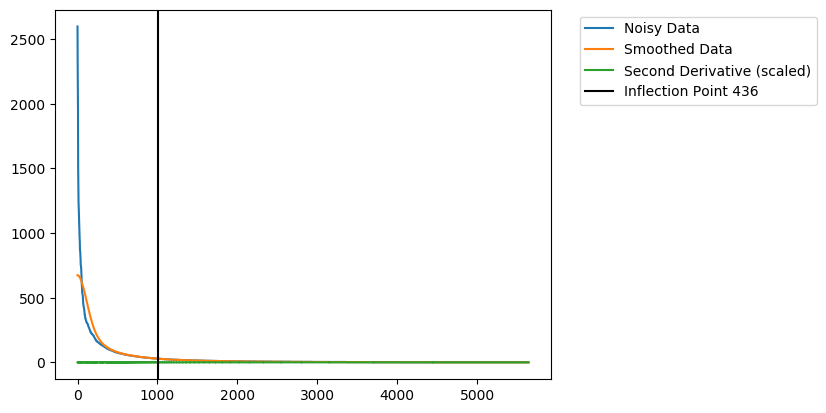

In [26]:
# plot results
plt.plot(my_spell_check_dictionary_df['freq'], label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    if(infl>1000 and infl<1010):
       plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
       break
plt.legend(bbox_to_anchor=(1.55, 1.0))

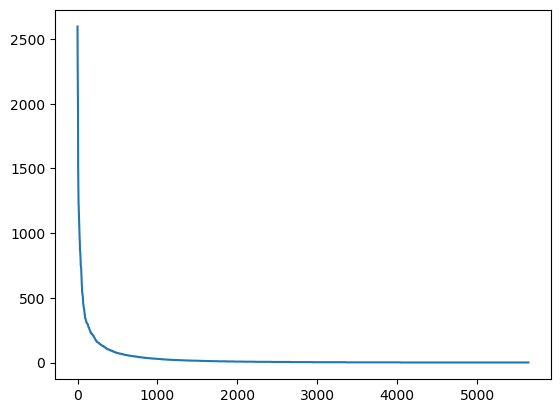

In [27]:
plt.plot(my_spell_check_dictionary_df['freq'], label='Noisy Data')


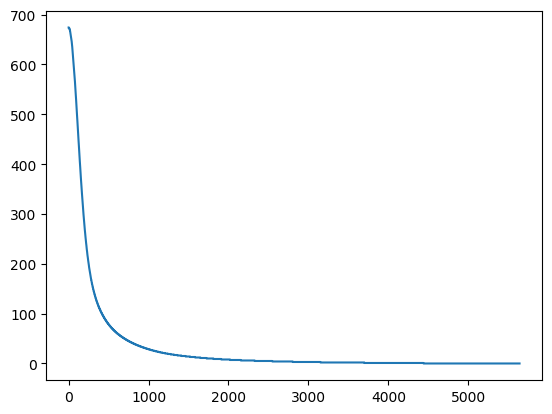

In [28]:
plt.plot(smooth, label='Smoothed Data')


In [29]:
my_spell_check_dictionary_df.head(10).style.background_gradient(cmap='Blues')

## Selecting data left of inflecxion as corpus and right as WHat needs to be corrected 

In [30]:
correct_corpus = my_spell_check_dictionary_df[my_spell_check_dictionary_df['freq'] >= 50] 
to_be_corrected = my_spell_check_dictionary_df[my_spell_check_dictionary_df['freq'] < 50] 

In [31]:
correct_corpus= correct_corpus[['products']].reset_index(drop= True)
to_be_corrected= to_be_corrected[['products']].reset_index(drop= True)

In [32]:
correct_corpus

products
0           oil
1           dal
2         parle
3        masala
4     britannia
..          ...
693       guard
694         gur
695         kam
696  cheeslings
697        eggs

[698 rows x 1 columns]

In [33]:
to_be_corrected

products
0        sham
1      pravin
2     bathing
3      litchi
4       large
...       ...
4940     coke
4941    cokie
4942   cokies
4943    pikal
4944  garbags

[4945 rows x 1 columns]

## Levenshtein distance operations are the removal, insertion, or substitution 


In [34]:
# Levenshtein distance operations are the removal, insertion, or substitution of a character in the string. Being the most common metric,
# the term Levenshtein distance is often used interchangeably with edit distance.
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [35]:
correct_word_listt =[]

In [36]:
correct_incorrect_df = pd.DataFrame(index=range(0,896),columns=['correct_word','incorrect_word'])

## Dataframe comprising correct word with there respective Missplelled word 

In [37]:
#Dictionary Mapping
correct_word_listt =[]
count = 0
k=0
for i in range(len(to_be_corrected['products'])):
    
    for j in range(len(correct_corpus['products'])):
        if len(correct_corpus['products'][j]) - len(to_be_corrected['products'][i]) <=1:
            if  (levenshteinDistance(correct_corpus['products'][j],to_be_corrected['products'][i]) == 1):
                correct_incorrect_df['correct_word'][k]= correct_corpus['products'][j]
                correct_incorrect_df['incorrect_word'][k]= to_be_corrected['products'][i]
                to_be_corrected['products'][i] = correct_corpus['products'][j]
                #correct_word_listt[count]=  correct_corpus['products'][j]
                #correct_word_listt.append(correct_corpus['products'][j])
                k+=1
                #count +=1
                break

In [174]:
correct_incorrect_df.head(10)

correct_word incorrect_word
0        paste          taste
1       chakki         chikki
2          eve           ever
3         poha           powa
4         roll          rolls
5         beet           best
6          box            bon
7        dairy          daily
8          eno            eng
9          big            bis

## Correcting the words in the list of Transactions 

In [175]:
count=0
for i in range(len(transactions)):
    for j in range(len(transactions[i])):
        corrected_name= ''
        for word in transactions[i][j].split():
            if(corrected_name==''):
                corrected_name=' '
            for l in range(len(correct_incorrect_df['incorrect_word'])):
                if(word==correct_incorrect_df['incorrect_word'][l]):
                    word= correct_incorrect_df['correct_word'][l]
                    corrected_name += word 
                    transactions[i][j] = corrected_name
            count+=1        


In [38]:
count

0

In [39]:
print(transactions)

[['brinjal', 'lady finger', 'green chilli'], ['colgate strong teeth tooth paste', 'lifebuoy neem and aloe vera soap'], ['naturo alma cand frt', 'karachis fruit biscuits', 'prl top but bis'], ['aashirvaad shudh chakki whole wheat atta', 'aashirvaad superior atta', 'hira moti wada lachkari rice', 'gow ghee', 'cadbury bournvita five star magic chocolate drink', 'wagh bakri premium leaf tea', 'gowardhan cow ghee'], ['durex feel thin condom', 'sat isabgol'], ['tide lemon mint', 'rin bar', 'vim bar', 'medimix ayu soap'], ['kismis raisins', 'badam'], ['tendli', 'garlic', 'kheera', 'onion', 'grapes green'], ['everest chaat masala', 'amul cheese slice', 'nestle maggi rich tomato ketchup', 'chings schezwan chutney', 'cadbury star chocolate bar'], ['tresemme hair spa shm', 'yardley london luxury jasmine soap pack'], ['clinic plus strong long shampoo', 'head shoulder anti dandruff shampoo anti hairfall'], ['parle monaco classic regular', 'parle krack jack biscuit', 'parle namkeen khatta meetha', '

# Data Preprocessing


In [40]:
#Data Preprocessing
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
transaction = np.array(transactions)

In [41]:
transaction

array([list(['brinjal', 'lady finger', 'green chilli']),
       list(['colgate strong teeth tooth paste', 'lifebuoy neem and aloe vera soap']),
       list(['naturo alma cand frt', 'karachis fruit biscuits', 'prl top but bis']),
       ...,
       list(['haldiram aloo bhujia sev', 'madhur pure hygienic sugar']),
       list(['dettol soothe', 'sarvodaya atta', 'sugar bulk', 'gala hardy']),
       list(['sugar', 'toor dal'])], dtype=object)

In [42]:
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
te_ary

te_ary= te_ary.astype("int")

te.columns_

import pandas as pd
dataset= pd.DataFrame(te_ary, columns=te.columns_)

In [44]:
maret_basket_analysis_= copy.deepcopy(maret_basket_analysis)
maret_basket_analysis_.reset_index(drop=True, inplace= True)
maret_basket_analysis_.head()

count                                       0    \
0                      Amul Vanilla Cup (65 ml)   
1                                       Brinjal   
2      Colgate Strong Teeth Tooth Paste (300 g)   
3                    Naturo-Alma/Cand/Frt*500Gm   
4                     Savlon Hand Sani Gel 55Ml   

count                                      1                     2    3    \
0                                          NaN                   NaN  NaN   
1                                  Lady Finger          Green chilli  NaN   
2      Lifebuoy Neem And Aloe Vera Soap (59 g)                   NaN  NaN   
3              Karachis Fruit Biscuits (200 g)  Prl-Top/But/Bis*90Gm  NaN   
4                                          NaN                   NaN  NaN   

count  4    5    6    7    8    9    ...  139  140  141  142  143  144  145  \
0      NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

count  146  147  148  
0      NaN  NaN  NaN  
1      NaN  NaN  NaN  
2      NaN  NaN  NaN  
3      NaN  NaN  NaN  
4      NaN  NaN  NaN  

[5 rows x 149 columns]

In [46]:
dataset

aachi appalam  aachi bajji bonda  aachi biriyani masala  \
0      0              0                  0                      0   
1      0              0                  0                      0   
2      0              0                  0                      0   
3      0              0                  0                      0   
4      0              0                  0                      0   
...   ..            ...                ...                    ...   
16369  0              0                  0                      0   
16370  0              0                  0                      0   
16371  0              0                  0                      0   
16372  0              0                  0                      0   
16373  0              0                  0                      0   

       aachi chicken  aachi chicken masala  aachi chilli  aachi chilly powder  \
0                  0                     0             0                    0   
1                  0                     0             0                    0   
2                  0                     0             0                    0   
3                  0                     0             0                    0   
4                  0                     0             0                    0   
...              ...                   ...           ...                  ...   
16369              0                     0             0                    0   
16370              0                     0             0                    0   
16371              0                     0             0                    0   
16372              0                     0             0                    0   
16373              0                     0             0                    0   

       aachi cumin powder  aachi fish fry masala  ...  zig zag neem  \
0                       0                      0  ...             0   
1                       0                      0  ...             0   
2                       0                      0  ...             0   
3                       0                      0  ...             0   
4                       0                      0  ...             0   
...                   ...                    ...  ...           ...   
16369                   0                      0  ...             0   
16370                   0                      0  ...             0   
16371                   0                      0  ...             0   
16372                   0                      0  ...             0   
16373                   0                      0  ...             0   

       zigzag kharata plastic broom  zindagi stevia sachets tea bags  \
0                                 0                                0   
1                                 0                                0   
2                                 0                                0   
3                                 0                                0   
4                                 0                                0   
...                             ...                              ...   
16369                             0                                0   
16370                             0                                0   
16371                             0                                0   
16372                             0                                0   
16373                             0                                0   

       zio coconut oil  zio groundnut oil  zio plus oil  \
0                    0                  0             0   
1                    0                  0             0   
2                    0                  0             0   
3                    0                  0             0   
4                    0                  0             0   
...                ...                ...           ...   
16369                0                  0             0   
16370             

#  Main Concepts of Association Rules / Apriori Algorithm

## Support
### Support is an indication of how frequently the itemset appears in the dataset. In other words, this is an indication of how popular an itemset is in a dataset
### support(A)= frequency(A in Transactions)/ Total_Transactions

## Confidence(or Conditional Probability)
### Confidence is an indication of how often the rule has been found to be true In other words, confidence says how likely item Y is purchased when item X is purchased.
### Or Probability of ocuurence of product B given that product A has already occured.
### confidence(B -> A) = support(A,B)/support(B)
### or confience(B->A) = Probability(A and B) / prob(B)

## Lift
### Lift is a ratio of observed support to that expected if X and Y were independent. In other words, lift illustrates how likely item Y is purchased when item X is purchased, while controlling for how popular item Y is. If the rule had a lift of 1, it would imply that the probability of occurrence of the antecedent and that of the consequent are independent of each other. When two events are independent of each other, no rule can be drawn involving those two events. If the lift is > 1, that lets us know the degree to which those two occurrences are dependent on one another, and makes those rules potentially useful for predicting the consequent in future data sets. f the lift is < 1, that lets us know the items are substitute to each other. This means that presence of one item has negative effect on presence of other item and vice versa. Therefore having lift bigger than 1 is critial for proving associations

### Lift = support(A,B)/support(A)*support(B) 


### Using Apriori to Frequent PAtterns

In [74]:
#5. Algorithm Implementation
#The most widely used library for Arules implementations is 'Mlxtend'. We will be using that library as well
# Extracting the most frequest itemsets via Mlxtend.
# The length column has been added to increase ease of filtering.

frequent_itemsets = apriori(dataset, min_support=0.003, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

support                                itemsets  length
0    0.003970                       (aashirvaad atta)       1
1    0.003359          (aashirvaad select wheat atta)       1
2    0.003603                       (aashirwaad atta)       1
3    0.023696                           (amul butter)       1
4    0.003481                       (amul buttermilk)       1
..        ...                                     ...     ...
339  0.003176  (green chilli, tomato, ginger, garlic)       4
340  0.003420         (onion, tomato, ginger, garlic)       4
341  0.003603   (onion, green chilli, tomato, garlic)       4
342  0.003970   (green chilli, tomato, ginger, onion)       4
343  0.003420    (potato, lady finger, tomato, onion)       4

[344 rows x 3 columns]

### Using Fp-Growth to generate frequent patterns

In [94]:
from mlxtend.frequent_patterns import fpgrowth

frequent_itemsets_fp=fpgrowth(dataset, min_support=0.003, use_colnames=True)
frequent_itemsets_fp['length'] = frequent_itemsets_fp['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fp

support                                           itemsets  length
0    0.023452                                     (green chilli)       1
1    0.022597                                      (lady finger)       1
2    0.019299                                          (brinjal)       1
3    0.003115                               (gowardhan cow ghee)       1
4    0.006901                                          (vim bar)       1
..        ...                                                ...     ...
339  0.003970                        (lady finger, cauli flower)       2
340  0.003115                       (shimla mirch, cauli flower)       2
341  0.004275                             (tomato, cauli flower)       2
342  0.006168  (maggi masala magic, ching secret schezwan sauce)       2
343  0.003054                                 (capsicum, tomato)       2

[344 rows x 3 columns]

It can be noticed that the frequent patterns generated by both algorithms are same but Fp-growth generates faster cause it uses Tree based approach hence it traverses the whole data only few times to generate frequent patterns.

### Making Association rules

## Consequents & Antecedents
### The IF component of an association rule is known as the antecedent. The THEN component is known as the consequent. The antecedent and the consequent are disjoint; they have no items in common.

In [95]:
#      We set our metric as "Lift" to define whether antecedents & consequents are dependent our not.
#      Treshold is selected as "1.2" since it is required to have lift scores above than 1 if there is dependency.

rules = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.2)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules= rules.sort_values("lift",ascending=False)

In [100]:
rules

antecedents  \
0    (rasoi magic dal makhani, ching secret schezwa...   
1                     (sensodyne toothpaste fresh gel)   
2        (rasoi magic dal makhani, maggi masala magic)   
3                            (rasoi magic dal makhani)   
4                        (ching secret schezwan sauce)   
..                                                 ...   
627                                            (onion)   
628                                            (onion)   
629                                            (onion)   
630                                            (onion)   
631                                            (onion)   

                       consequents  antecedent support  consequent support  \
0             (maggi masala magic)            0.004947            0.015451   
1                      (tata salt)            0.003359            0.037743   
2    (ching secret schezwan sauce)            0.005313            0.007023   
3             (maggi masala magic)            0.005802            0.015451   
4             (maggi masala magic)            0.007023            0.015451   
..                             ...                 ...                 ...   
627           (lemon, lady finger)            0.059423            0.006901   
628               (potato, ginger)            0.059423            0.004580   
629          (lady finger, ginger)            0.059423            0.005374   
630                       (nenuaa)            0.059423            0.005863   
631                 (bitter gourd)            0.059423            0.004764   

      support  confidence        lift  leverage  conviction  \
0    0.004886    0.987654   63.920363  0.004809   79.748443   
1    0.003298    0.981818   26.013416  0.003171   52.924148   
2    0.004886    0.919540  130.926537  0.004848   12.341281   
3    0.005313    0.915789   59.269316  0.005224   11.691516   
4    0.006168    0.878261   56.840488  0.006060    8.087364   
..        ...         ...         ...       ...         ...   
627  0.003176    0.053443    7.744027  0.002766    1.049170   
628  0.003176    0.053443   11.667667  0.002904    1.051621   
629  0.003115    0.052415    9.752803  0.002795    1.049643   
630  0.003054    0.051387    8.764774  0.002705    1.047991   
631  0.003054    0.051387   10.787414  0.002771    1.049149   

     antecedents_length  consequents_length  
0                     2                   1  
1                     1                   1  
2                     2                   1  
3                     1                   1  
4                     1                   1  
..                  ...                 ...  
627                   1                   2  
628                   1                   2  
629                   1                   2  
630                   1                   1  
631                   1                   1  

[632 rows x 11 columns]

### Distribution plots

In [101]:
rules = rules.sort_values(by=['support'], ascending=False).reset_index(drop=True)

### Support

(0, 0.025)

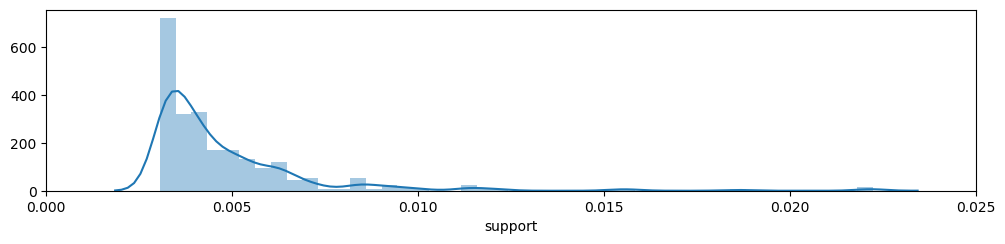

In [122]:
# Code to reproduce the plot below
import seaborn as sb
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(311)
sb.distplot(rules['support'])
#plt.title('y_test')
plt.xlim([0, 0.025])

### Confidence

(0, 1)

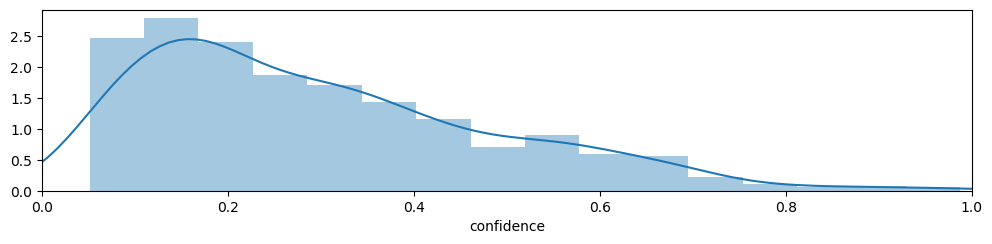

In [113]:
rules = rules.sort_values(by=['confidence'], ascending=False).reset_index(drop=True)
# Code to reproduce the plot below
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(311)
sb.distplot(rules['confidence'], hist=True, kde= True)
#plt.title('y_test')
plt.xlim([0, 1])

### Lift

(1, 150)

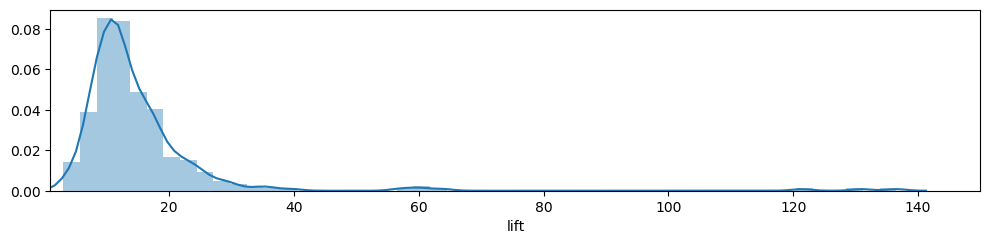

In [123]:
    # Code to reproduce the plot below
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(311)
sb.distplot(rules['lift'])
#plt.title('y_test')
plt.xlim([1, 150 ])

# Exporting Association Rules

In [103]:
rules.to_excel('results.xlsx', engine='xlsxwriter')
rules.to_excel(r'H:\intern_lovelocal\ML_Project\association_rules_.xlsx', index = False)

# Visualizing results


### 1.Support vs Confidence


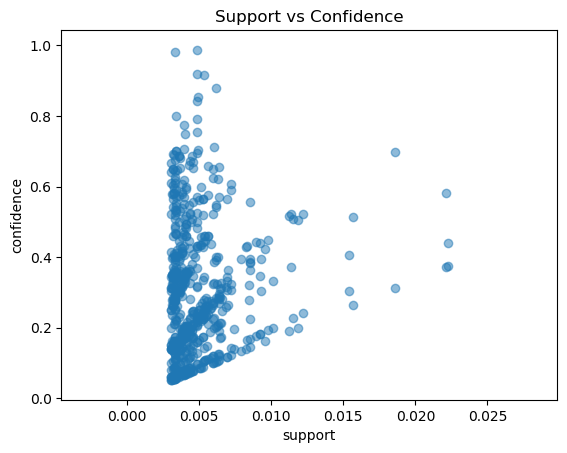

In [58]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

### 2. Support vs Lift


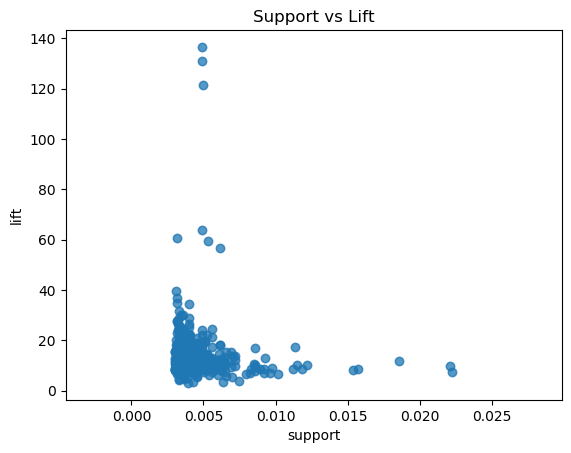

In [124]:
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

### 3. Lift vs Confidence


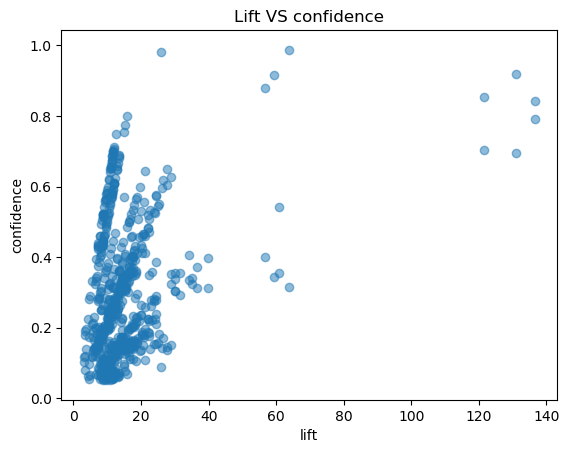

In [125]:
plt.scatter(rules['lift'], rules['confidence'], alpha=0.5)
plt.xlabel('lift')
plt.ylabel('confidence')
plt.title('Lift VS confidence')
plt.show()

### Sorting Data according to support to Plot the Inflexion point 

In [78]:
rules = rules.sort_values(by=['support'], ascending=False).reset_index(drop=True)

## Getting Inflexion Point, to get optimum threshold support, confidence and lift values

### Support

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# smooth
smooth = gaussian_filter1d(rules['support'], 100)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

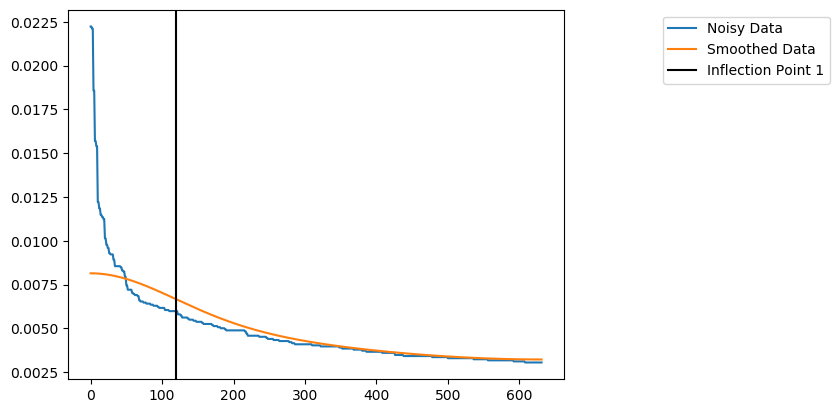

In [80]:
# plot results
plt.plot(rules['support'], label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
#plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    #if(infl>500 and infl<1000):
       plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
       
plt.legend(bbox_to_anchor=(1.55, 1.0))

Inflexion point says that the Support(freq of product ocuurnece in trans/ total transactions ) should be greater than "0.0058" to encorporate maximum association rules.

### Confidence

In [75]:
rules = rules.sort_values(by=['confidence'], ascending=False).reset_index(drop=True)
# smooth
smooth = gaussian_filter1d(rules['confidence'], 100)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

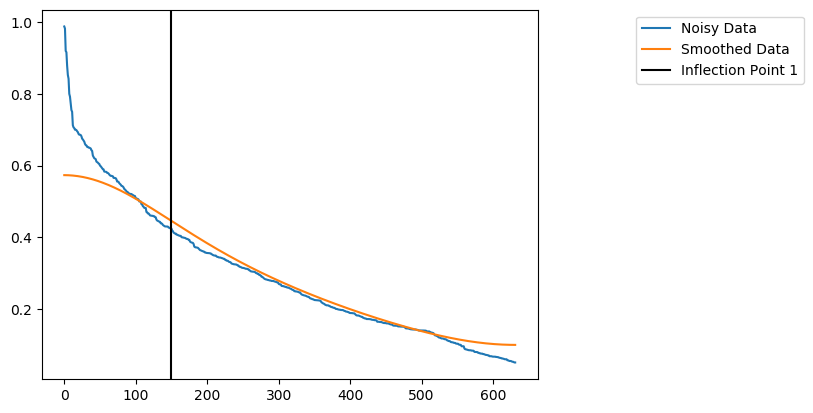

In [76]:
# plot results
plt.plot(rules['confidence'], label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
#plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    #if(infl>500 and infl<1000):
       plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
       
plt.legend(bbox_to_anchor=(1.55, 1.0))

### Lift

In [83]:
rules = rules.sort_values(by=['lift'], ascending=False).reset_index(drop=True)
# smooth
smooth = gaussian_filter1d(rules['lift'], 100)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
infls = np.where(np.diff(np.sign(smooth_d2)))[0]

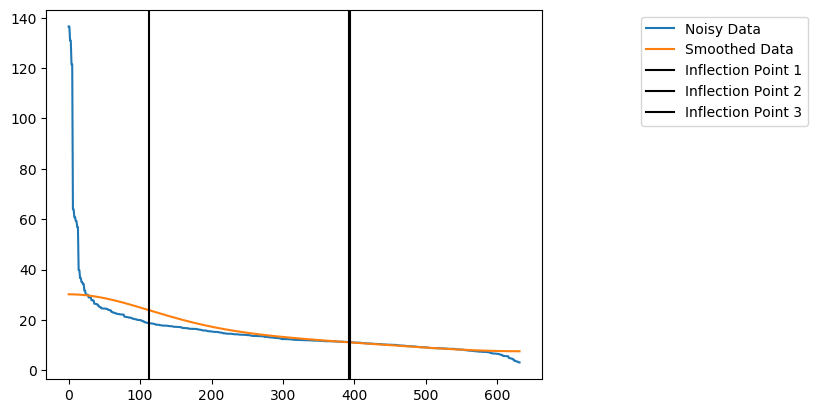

In [84]:
# plot results
plt.plot(rules['lift'], label='Noisy Data')
plt.plot(smooth, label='Smoothed Data')
#plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
for i, infl in enumerate(infls, 1):
    #if(infl>500 and infl<1000):
       plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
       
plt.legend(bbox_to_anchor=(1.55, 1.0))